In [1]:
import pickle
import re
import time
import warnings

import matplotlib.pyplot as plt
import nltk
import pandas as pd
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tqdm.auto import tqdm

nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/Michael.Jenkins/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Michael.Jenkins/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Michael.Jenkins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Michael.Jenkins/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("./labeled_data/labeled_foi_text_2023_05_01.csv")

In [3]:
ps = PorterStemmer()  # creating an instance of the class

In [4]:
def preprocess_text(text):
    """In preprocess_text function we will apply all the things that are given below:
    - removing special characters
    - removing punctuations
    - removing numbers
    - removing stopwords
    - doing stemming
    - transforming in lowercase
    - removing excessive whitespaces
    """
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", str(text))

    # remove punctuations in string
    text = re.sub(r"[^\w\s]", "", str(text))

    # 1. tokenize
    tokens = nltk.word_tokenize(text)

    # 2. check if stopword and stemming the word
    tokens = [ps.stem(w) for w in tokens if w.lower() not in stopwords.words("english")]

    # 3. join back together
    text = " ".join(tokens)

    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()

    return text

In [5]:
df["clean_text"] = df["FOI_TEXT"].apply(lambda x: preprocess_text(x))
df.head()

,ROW_ID,FOI_TEXT,PRIMARY_LABEL,clean_text
0,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,Quality Engineering,report transmitt lost connect pump greater hou...
1,1426265,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,Quality Engineering,report signal loss one hour occur product data...
2,2609625,IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...,Quality Engineering,report transmitt fail error occur data evalu a...
3,2813837,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,Quality Engineering,report signal loss one hour occur review share...
4,1337517,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,Quality Engineering,report signal loss one hour occur product eval...


In [6]:
# define a function for getting all words from the text


def returning_tokinize_list(df, column_name):
    df = df.reset_index(drop=True)
    tokenize_list = [nltk.word_tokenize(df[column_name][i]) for i in range(df.shape[0])]
    final = [j for i in tokenize_list for j in i]
    return final

In [7]:
# get the all words of text into list
tokenize_list_words = returning_tokinize_list(df, "clean_text")

In [8]:
# function for words in dataframe format


def table_format(data_list, column_name):
    df_ = pd.DataFrame(data_list, columns=[column_name, "Frequency_distribution"])
    return df_


# function for extracting the most common words in reviews text
def most_common_words(cleaned_col_name_list, common_words=10):
    fdist = FreqDist(cleaned_col_name_list)
    most_common = fdist.most_common(common_words)
    return most_common

In [9]:
label_enc = LabelEncoder()
df["PRIMARY_LABEL_ENC"] = label_enc.fit_transform(df["PRIMARY_LABEL"])

In [10]:
label_enc.classes_

array(['Design Engineer', 'Management', 'Manufacturing Engineer',
       'Quality Engineering', 'Stakeholder Unassigned'], dtype=object)

In [11]:
X = df["clean_text"]  # independent feature
y = df["PRIMARY_LABEL_ENC"]  # dependent feature

In [12]:
def splitting_dataset(X, y, test_size=0.25):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0, stratify=y
    )
    return X_train, X_test, y_train, y_test

In [13]:
def get_features_from_text(X):
    # Fit and transform the data to a document-term matrix using TfidfVectorizer
    tfidf = TfidfVectorizer(min_df=2)
    X_tfidff = tfidf.fit_transform(X.values)
    print("Number of features TF-IDF: %d" % len(tfidf.get_feature_names_out()))

    with open("./labeled_data/svm_tfidf.pickle", "wb") as f:
        pickle.dump(tfidf, f)

    return X_tfidff.toarray()

In [14]:
X_tfidff = get_features_from_text(X)

Number of features TF-IDF: 470


In [15]:
oversample = SMOTE(random_state=42)
overX, overY = oversample.fit_resample(X_tfidff, y)
pd.DataFrame(overY)["PRIMARY_LABEL_ENC"].value_counts()

PRIMARY_LABEL_ENC
3    3355
4    3355
0    3355
1    3355
2    3355
Name: count, dtype: int64

In [16]:
# split data into 75% training and 25% testing set
X_train_tfidf, X_test_tfidf, y_train, y_test = splitting_dataset(
    overX, overY, test_size=0.25
)

In [17]:
def results(model, y_pred, y_test):
    accuracy = round(accuracy_score(y_pred, y_test) * 100, 4)
    precision = round(precision_score(y_pred, y_test, average="macro") * 100, 4)
    recall = round(recall_score(y_pred, y_test, average="macro") * 100, 4)
    f1_scr = round(f1_score(y_pred, y_test, average="macro") * 100, 4)

    print("\nAccuracy: {}%".format(accuracy))
    print("Precision: {}%".format(precision))
    print("Recall: {}%".format(recall))
    print("F1-Score: {}%".format(f1_scr))
    print()
    print("Classification Report:")
    print(classification_report(y_pred, y_test, target_names=label_enc.classes_))
    print()
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_pred,
        y_test,
        ax=ax,
        display_labels=label_enc.classes_,
        xticks_rotation="vertical",
    )
    plt.show()

    return {
        "Model": model.__class__.__name__,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1_scr,
    }

In [18]:
def train_model(model):
    # Record the start time
    start_time = time.time()

    # Fit the model on the training data
    model.fit(X_train_tfidf, y_train)

    # Record the end time
    end_time = time.time()

    # Compute the training time in seconds
    training_time = end_time - start_time
    print(f"Training time: {training_time:.3f} seconds")

    # predict the model on testing data
    y_pred = model.predict(X_test_tfidf)

    # get results
    RESULTS_LR = results(model, y_pred, y_test)

    # Add the training time to RESULTS_LR
    RESULTS_LR["Training time (s)"] = training_time

    return RESULTS_LR

In [19]:
def get_model_results(res):
    # Convert the dictionary to a DataFrame
    return pd.DataFrame.from_dict([res]).set_index("Model")

In [20]:
model_tuple = [
    (
        "SVM",
        SVC(
            **{
                "C": 10,
                "decision_function_shape": "ovr",
                "kernel": "rbf",
                "random_state": 42,
            }
        ),
    ),
]

model running:   0%|          | 0/1 [00:00<?, ?it/s]

			 SVM
Training time: 8.612 seconds

Accuracy: 83.0234%
Precision: 83.0259%
Recall: 84.1032%
F1-Score: 82.8634%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.98      0.99       855
            Management       0.74      0.71      0.72       884
Manufacturing Engineer       0.94      0.72      0.81      1093
   Quality Engineering       0.61      0.83      0.71       617
Stakeholder Unassigned       0.86      0.97      0.91       745

              accuracy                           0.83      4194
             macro avg       0.83      0.84      0.83      4194
          weighted avg       0.85      0.83      0.83      4194


Confusion Matrix:


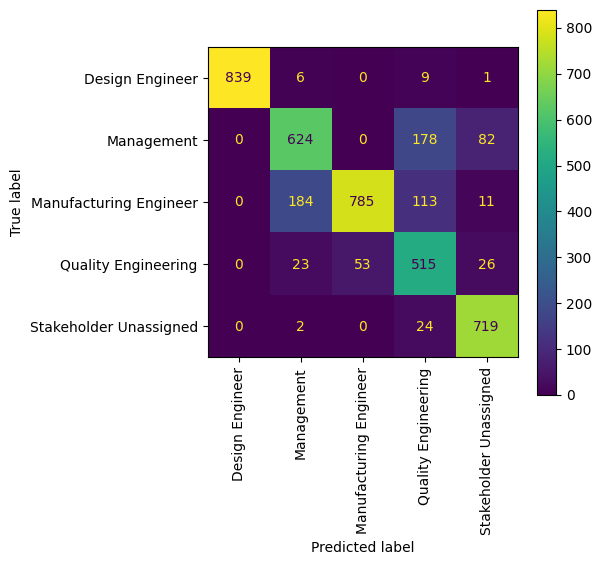

       Accuracy  Precision   Recall       F1  Training time (s)
Model                                                          
SVC     83.0234    83.0259  84.1032  82.8634           8.611965



In [21]:
for model_name, model in tqdm(model_tuple, desc="model running"):
    print("=" * 100)
    print(f"\t\t\t {model_name}")
    print("=" * 100)

    # Record the start time
    start_time = time.time()

    # Fit the model on the training data
    model.fit(X_train_tfidf, y_train)

    # Record the end time
    end_time = time.time()

    # Compute the training time in seconds
    training_time = end_time - start_time
    print(f"Training time: {training_time:.3f} seconds")

    # predict the model on testing data
    y_pred = model.predict(X_test_tfidf)

    # get results
    RESULT = results(model, y_pred, y_test)

    # Add the training time to RESULTS_LR
    RESULT["Training time (s)"] = training_time

    df_results = get_model_results(RESULT)
    print(df_results)
    print()

In [23]:
# Save the trained model to a file
with open('./labeled_data/svm_model.pickle', 'wb') as f:
    pickle.dump(model, f)